In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('final_travel_time.csv')

In [10]:
df.head()

,road_segment,datetime,travel_time
0,0,2019-12-23 05:00:00,1.864865
1,0,2019-12-05 05:00:02,1.619718
2,0,2019-12-12 05:00:04,1.751269
3,0,2019-12-29 05:00:04,1.932773
4,0,2019-12-12 05:00:05,2.284768


In [11]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [12]:
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['is_peakhour'] = df['hour'].apply(lambda x: 1 if (8 <= x <= 11 or 16 <= x <= 18) else 0)
df['is_weekend'] = df['datetime'].dt.dayofweek.apply(lambda x: 1 if x == 5 else 0)
df.head()

,road_segment,datetime,travel_time,hour,minute,is_peakhour,is_weekend
0,0,2019-12-23 05:00:00,1.864865,5,0,0,0
1,0,2019-12-05 05:00:02,1.619718,5,0,0,0
2,0,2019-12-12 05:00:04,1.751269,5,0,0,0
3,0,2019-12-29 05:00:04,1.932773,5,0,0,0
4,0,2019-12-12 05:00:05,2.284768,5,0,0,0


In [13]:
features = ['road_segment','hour', 'minute', 'is_peakhour', 'is_weekend']
target = 'travel_time'

In [14]:
X = df[features].values
y = df[target].values

In [15]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

In [16]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [17]:
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [19]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs
    x = Dense(ff_dim, activation="relu")(res)
    x = Dense(inputs.shape[-1])(x)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [20]:
inputs = Input(shape=(1, len(features)))
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=4, dropout=0.2)
x = GlobalAveragePooling1D()(x)
x = Dense(20, activation="relu")(x)
outputs = Dense(1)(x)

In [21]:
model = Model(inputs=inputs, outputs=outputs)

In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [23]:
history = model.fit(X_train, y_train, epochs=500, batch_size=64, 
                    validation_split=0.2, verbose=1)

Epoch 1/500


c:\Users\Ripple\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2891 - val_loss: 0.0217
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0589 - val_loss: 0.0211
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - val_loss: 0.0208
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - val_loss: 0.0199
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0239 - val_loss: 0.0197
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235 - val_loss: 0.0201
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - val_loss: 0.0192
Epoch 8/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0218 - val_loss: 0.0190
Epoch 9/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - val_loss: 0.0189
Epoch 10/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0187
Epoch 11/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0207 - val_loss: 0.0186
Epoch 12/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0210 - val_l

In [24]:
model.save('transformer_travel_time.keras')

In [25]:
loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss (MSE): {loss}')

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057
Test Loss (MSE): 0.0058051166124641895


In [26]:
y_pred_scaled = model.predict(X_test)

 1/33 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step

c:\Users\Ripple\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [27]:
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

In [28]:
results = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': y_pred.flatten()})
print(results.head())

     Actual  Predicted
0  5.071823   5.605299
1  3.445545   2.317123
2  4.515789   5.419317
3  4.285714   5.183593
4  2.706625   3.102445


In [29]:
mae = mean_absolute_error(y_test_actual, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.8528027033336585


In [30]:
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.2753110115281046


In [31]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.626418176124837


In [32]:
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
print(f'Mean Absolute Percentage Error: {mape}%')

Mean Absolute Percentage Error: 23.044413401589882%


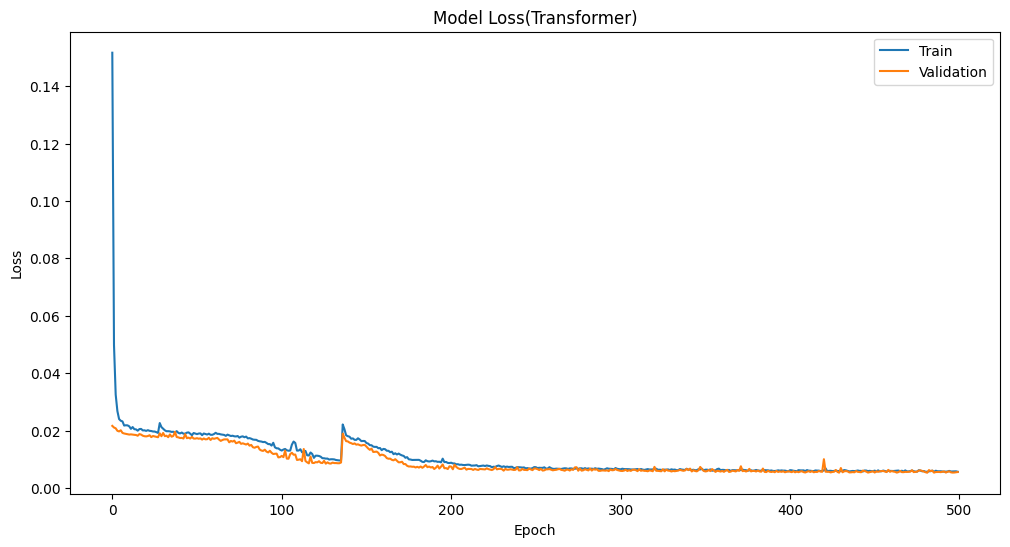

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss(Transformer)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('training_validation_loss.png')
plt.show()

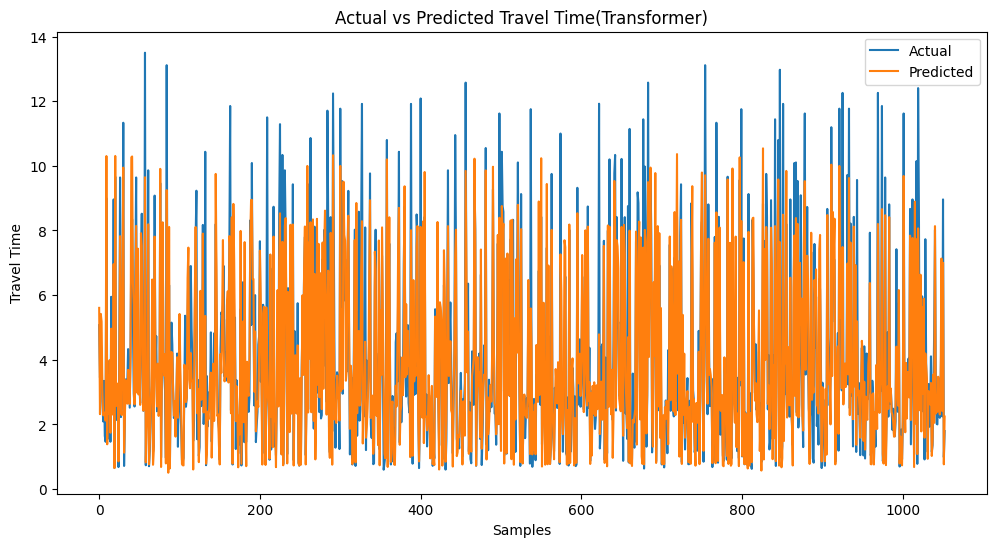

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Travel Time(Transformer)')
plt.xlabel('Samples')
plt.ylabel('Travel Time')
plt.legend()
plt.savefig('Actual vs Predicted Travel Time.png')
plt.show()

In [35]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

['scaler_y.pkl']

In [36]:
def calculate_accuracy(expected_times, actual_times):
    n = len(expected_times)    
    sum_term = sum(1 - abs((expected_times[i] - actual_times[i]) / actual_times[i]) for i in range(n))
    accuracy = (sum_term / n) * 100
    return accuracy
accuracy = calculate_accuracy(y_test_actual.flatten(), y_pred.flatten())
print(f"Accuracy on Validation Set: {accuracy:.2f}%")

Accuracy on Validation Set: 74.62%
